## Importing Libraries

In [1]:
from __future__ import division, print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

## Importing Data

In [2]:
mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:

def train_size(num):
    print ('Total Training Images in Dataset = ' + str(mnist.train.images.shape))
    print ('--------------------------------------------------')
    x_train = mnist.train.images[:num,:]
    print ('x_train Examples Loaded = ' + str(x_train.shape))
    y_train = mnist.train.labels[:num,:]
    print ('y_train Examples Loaded = ' + str(y_train.shape))
    print('')
    return x_train, y_train


In [4]:
def test_size(num):
    print ('Total Test Examples in Dataset = ' + str(mnist.test.images.shape))
    print ('--------------------------------------------------')
    x_test = mnist.test.images[:num,:]
    print ('x_test Examples Loaded = ' + str(x_test.shape))
    y_test = mnist.test.labels[:num,:]
    print ('y_test Examples Loaded = ' + str(y_test.shape))
    return x_test, y_test



In [5]:

def display_digit(num):
    print(y_train[num])
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()


Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (55000, 784)
y_train Examples Loaded = (55000, 10)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


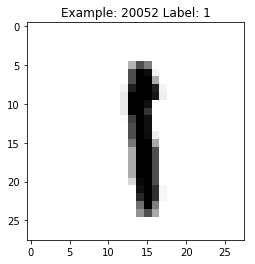

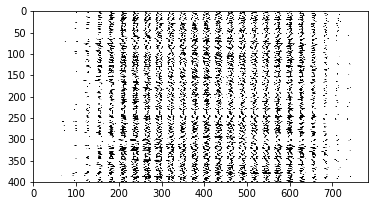

In [6]:

def display_mult_flat(start, stop):
    images = x_train[start].reshape([1,784])
    for i in range(start+1,stop):
        images = np.concatenate((images, x_train[i].reshape([1,784])))
        
    plt.imshow(images, cmap=plt.get_cmap('gray_r'))
    plt.show()
x_train, y_train = train_size(55000)
display_digit(np.random.randint(0, x_train.shape[0]))
display_mult_flat(0,400)

In [7]:

# Parameters
learning_rate = 0.001
training_iters = 500
batch_size = 128
display_step = 10
# Network Parameters
n_input = 784                             # MNIST data input (img shape: 28*28)
n_classes = 10                            # MNIST total classes (0-9 digits)
dropout = 0.85                            # Dropout, probability to keep units




## Placeholders

In [8]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)


## Covolutional and MAxpooling functions

In [9]:

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1],padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k,1], padding='SAME')


In [10]:

def conv_net(x, weights, biases, dropout):
    # reshape the input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    # First convolution layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling used for downsampling
    conv1 = maxpool2d(conv1, k=2)
    # Second convolution layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling used for downsampling
    conv2 = maxpool2d(conv2, k=2)
    # Reshape conv2 output to match the input of fully connected layer
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    # Output the class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out


weights = { # 5x5 conv, 1 input, and 32 outputs
            'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
            # 5x5 conv, 32 inputs, and 64 outputs
            'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
            # fully connected, 7*7*64 inputs, and 1024 outputs
            'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
            # 1024 inputs, 10 outputs for class digits
            'out': tf.Variable(tf.random_normal([1024, n_classes]))}


biases = {  'bc1': tf.Variable(tf.random_normal([32])),
            'bc2': tf.Variable(tf.random_normal([64])),
            'bd1': tf.Variable(tf.random_normal([1024])),
            'out': tf.Variable(tf.random_normal([n_classes]))}



pred = conv_net(x, weights, biases, keep_prob)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer =tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()
    


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [20]:

train_loss = []
train_acc = []
test_acc = []
with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step <= training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        if step % display_step == 0:
            loss_train, acc_train = sess.run([cost, accuracy],feed_dict={x: batch_x,y: batch_y,keep_prob:1.})
            print("Iter " + str(step) + ", Minibatch Loss= " + "{:.2f}".format(loss_train) +", Training Accuracy= " + "{:.2f}".format(acc_train))
            # Calculate accuracy for 2048 mnist test images.
            # Note that in this case no dropout
            acc_test = sess.run(accuracy,feed_dict={x:mnist.test.images,y:mnist.test.labels,keep_prob: 1.0})
            print ("Testing Accuracy:" + "{:.2f}".format(acc_train))
            train_loss.append(loss_train)
        step+=1    
    

Iter 10, Minibatch Loss= 12348.21, Training Accuracy= 0.38
Testing Accuracy:0.38
Iter 20, Minibatch Loss= 7377.45, Training Accuracy= 0.63
Testing Accuracy:0.63
Iter 30, Minibatch Loss= 5864.31, Training Accuracy= 0.65
Testing Accuracy:0.65
Iter 40, Minibatch Loss= 4844.75, Training Accuracy= 0.73
Testing Accuracy:0.73
Iter 50, Minibatch Loss= 2822.73, Training Accuracy= 0.80
Testing Accuracy:0.80
Iter 60, Minibatch Loss= 3013.57, Training Accuracy= 0.80
Testing Accuracy:0.80
Iter 70, Minibatch Loss= 1631.03, Training Accuracy= 0.89
Testing Accuracy:0.89
Iter 80, Minibatch Loss= 2514.73, Training Accuracy= 0.88
Testing Accuracy:0.88
Iter 90, Minibatch Loss= 1984.06, Training Accuracy= 0.86
Testing Accuracy:0.86
Iter 100, Minibatch Loss= 2174.97, Training Accuracy= 0.90
Testing Accuracy:0.90
Iter 110, Minibatch Loss= 1176.00, Training Accuracy= 0.91
Testing Accuracy:0.91
Iter 120, Minibatch Loss= 499.92, Training Accuracy= 0.94
Testing Accuracy:0.94
Iter 130, Minibatch Loss= 1425.84, Tr